# Group Project / Assignment 3: Retrieval-Augmented Generation Question Answering
**Assignment due 6 April 11:59pm 2025**

Welcome to the third assignment for 50.055 Machine Learning Operations. 
The third and fourth assignment together form the course group project. You will be working in your project groups to build a chatbot which can answer questions about SUTD to prospective students.


**This assignment is a group assignment.**

- Read the instructions in this notebook carefully
- Add your solution code and answers in the appropriate places. The questions are marked as **QUESTION:**, the places where you need to add your code and text answers are marked as **ADD YOUR SOLUTION HERE**
- The completed notebook, including your added code and generated output will be your submission for the assignment.
- The notebook should execute without errors from start to finish when you select "Restart Kernel and Run All Cells..". Please test this before submission.
- Use the SUTD Education Cluster to solve and test the assignment. If you work on another environment, minimally test your work on the SUTD Education Cluster.

**Rubric for assessment** 

Your submission will be graded using the following criteria. 
1. Code executes: your code should execute without errors. The SUTD Education cluster should be used to ensure the same execution environment.
2. Correctness: the code should produce the correct result or the text answer should state the factual correct answer.
3. Style: your code should be written in a way that is clean and efficient. Your text answers should be relevant, concise and easy to understand.
4. Partial marks will be awarded for partially correct solutions.
5. Creativity and innovation: in this assignment you have more freedom to design your solution, compared to the first assignments. You can show of your creativity and innovative mindset. 
6. There is a maximum of 225 points for this assignment.

**ChatGPT policy** 

If you use AI tools, such as ChatGPT, to solve the assignment questions, you need to be transparent about its use and mark AI-generated content as such. In particular, you should include the following in addition to your final answer:
- A copy or screenshot of the prompt you used
- The name of the AI model
- The AI generated output
- An explanation why the answer is correct or what you had to change to arrive at the correct answer

**Assignment Notes:** Please make sure to save the notebook as you go along. Submission instructions are located at the bottom of the notebook.



### Retrieval-Augmented Generation (RAG) 

In this assignment, you will be building a Retrieval-Augmented Generation (RAG) question answering system which can answer questions about SUTD.

We'll be leveraging `langchain` and `llama 3.2`.

Check out the docs:
- [LangChain](https://docs.langchain.com/docs/)
- [Llama 3.2](https://www.llama.com/docs/model-cards-and-prompt-formats/llama3_2/)


The SUTD website used to allow chatting with current students. Unfortunately, this feature does not exist anymore. Let's build a chatbot to fill this gap!


### Conduct user research

What are the questions that prospective and current students have about SUTD? In week 2, you already conducted some user research to understand your users.

### Value Proposition Canvas


### QUESTION: 

Paste the value proposition canvas which you have created in week 2 into this notebook below. 


**--- ADD YOUR SOLUTION HERE (10 points) ---**

- (replace canvas image below)

------------------------------


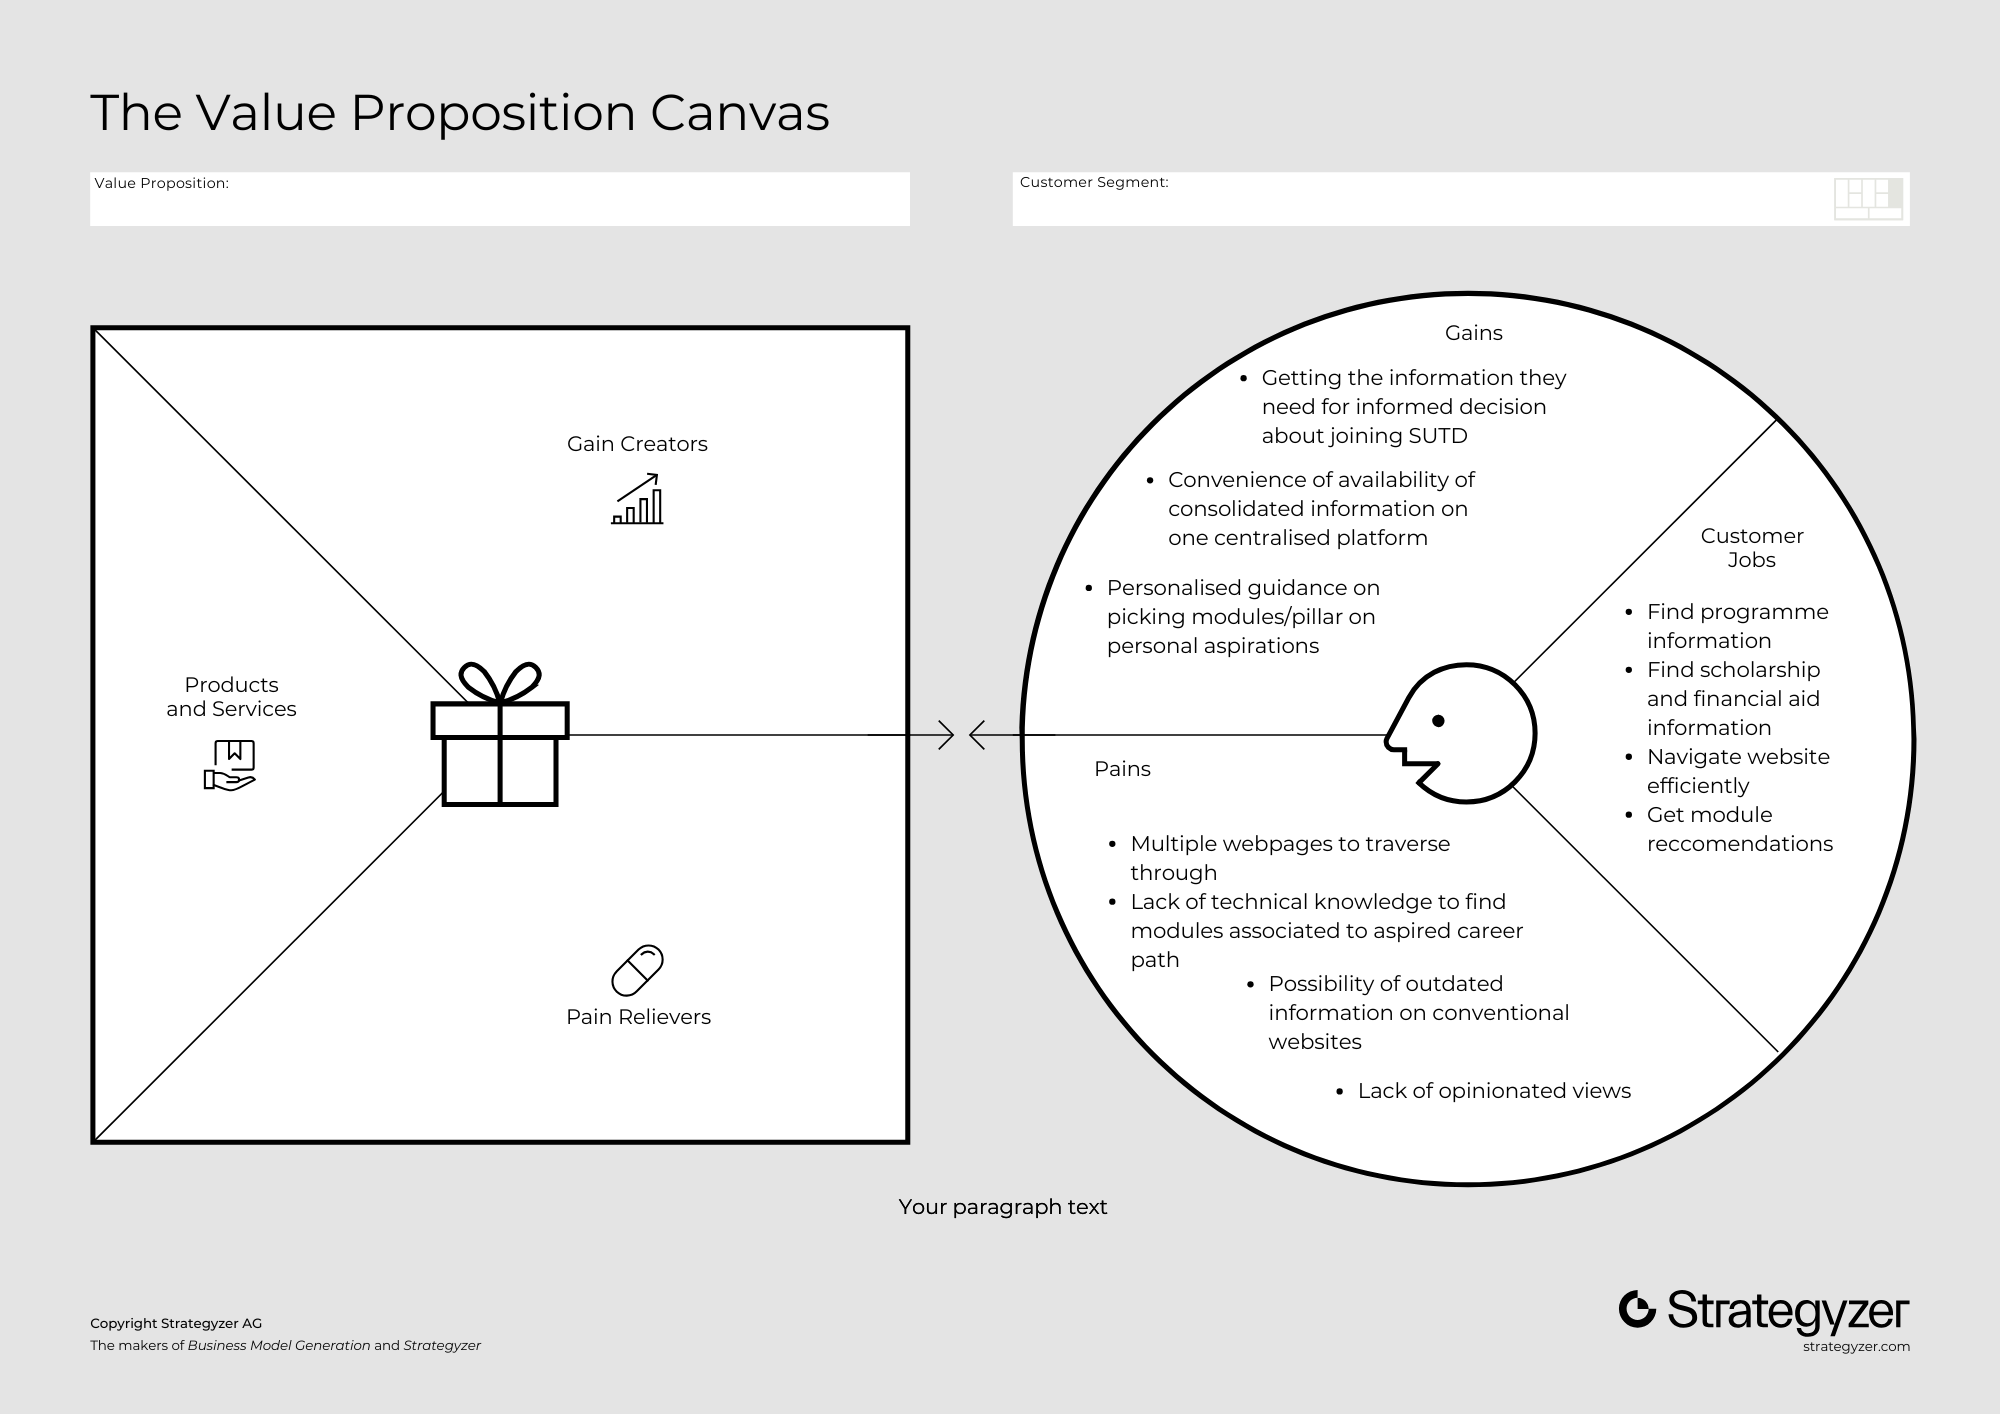

# Install dependencies
Use pip to install all required dependencies of this assignment in the cell below. Make sure to test this on the SUTD cluster as different environments have different software pre-installed.  

In [ ]:
# QUESTION: Install and import all required packages
# The rest of your code should execute without any import or dependency errors.

# **--- ADD YOUR SOLUTION HERE (10 points) ---**
! pip install langchain_community
! pip install langgraph
! pip install -qU langchain-huggingface
! pip install datasets
! pip install transformers[torch]
! pip install accelerate
! pip install llama-stack
! pip install -qU "langchain[openai]"
! pip install torch
! pip install "langchain[all]" langchain-huggingface transformers[torch] optimum accelerate
! pip install "numpy<2"
! pip install pypdf
# ----------------


In [14]:
from typing import Literal
import bs4
from langchain import hub
from langchain_community.document_loaders import WebBaseLoader
from langchain_core.documents import Document
from langchain_core.vectorstores import InMemoryVectorStore
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langgraph.graph import START, StateGraph
from typing_extensions import Annotated, List, TypedDict
from langchain_huggingface import HuggingFaceEmbeddings, HuggingFacePipeline
from datasets import load_dataset
from transformers import AutoModelForCausalLM,AutoTokenizer,pipeline
import torch
from langchain_core.output_parsers import PydanticOutputParser
import numpy
from langchain_core.messages import SystemMessage
from langgraph.prebuilt import ToolNode
from pypdf import PdfReader
import os
from os import listdir
from bs4 import BeautifulSoup
import pandas as pd
import re 
import requests
from tqdm import tqdm

# Download documents
The RAG application should be able to answer questions based on ingested documents. For the SUTD chatbot, download PDF and HTML files from the SUTD website. The documents should contain information about the admission process, available courses and the university in general.


In [ ]:
# QUESTION: Download documents from the SUTD website
# You should download at least 10 documents but more documents can increase the knowledge base of your chatbot.

# **--- ADD YOUR SOLUTION HERE (20 points) ---**
# Separated by different loaders because different webpage has content on different html element
loader = WebBaseLoader(
    web_paths=("https://en.wikipedia.org/wiki/Singapore_University_of_Technology_and_Design", 
               "https://www.sutd.edu.sg/research/research-centres/designz/about/introduction/",
               "https://www.sutd.edu.sg/admissions/undergraduate/education-expenses/fees/tuition-fees/#tabs",
               "https://www.sutd.edu.sg/admissions/undergraduate/education-expenses/fees/tuition-grant-eligibility/#tabs",
               "https://www.sutd.edu.sg/admissions/undergraduate/education-expenses/financial-estimates/#tabs",
               "https://www.sutd.edu.sg/admissions/undergraduate/education-expenses/student-insurance-scheme/#tabs",
               "https://www.sutd.edu.sg/admissions/undergraduate/appeal/",
               "https://www.sutd.edu.sg/admissions/undergraduate/admission-requirements/overview",
               "https://www.sutd.edu.sg/admissions/undergraduate/scholarship/sutd-administered/",
               "https://www.sutd.edu.sg/admissions/undergraduate/scholarship/external-sponsored/#tabs",
               "https://www.sutd.edu.sg/admissions/undergraduate/scholarship/awards/sutd-design-innovator-award/",
               "https://www.sutd.edu.sg/admissions/undergraduate/financing-options-and-aid/financial-aid/overview/#tabs",
               "https://www.sutd.edu.sg/admissions/undergraduate/financing-options-and-aid/other-financing-options/overview#tabs",
               "https://www.sutd.edu.sg/admissions/undergraduate/financing-options-and-aid/sutd-community-grant/#tabs",
               "https://www.sutd.edu.sg/admissions/undergraduate/early-matriculation/",
               "https://www.sutd.edu.sg/admissions/undergraduate/integrated-learning-programme/",
               "https://www.sutd.edu.sg/campus-life/student-life/student-organisations-fifth-row/",
               "https://www.sutd.edu.sg/campus-life/student-life/part-time-work-scheme/",
               "https://www.sutd.edu.sg/campus-life/student-life/student-awards/student-achievement-awards/overview/#tabs",
               "https://www.sutd.edu.sg/admissions/undergraduate/admission-requirements/international-qualifications",
               "https://www.sutd.edu.sg/admissions/undergraduate/application-guide/",
               "https://www.sutd.edu.sg/istd/139-2/",
                "https://www.sutd.edu.sg/course/10-013-modelling-and-analysis/",
               "https://www.sutd.edu.sg/course/10-015-physical-world/",
               "https://www.sutd.edu.sg/course/10-014-computational-thinking-for-design/",
               "https://www.sutd.edu.sg/course/02-001-global-humanities-literature-philosophy-and-ethics/",
               "https://www.sutd.edu.sg/course/10-018-modelling-space-and-systems/",
               "https://www.sutd.edu.sg/course/10-017-technological-world/",
               "https://www.sutd.edu.sg/course/10-016-science-for-a-sustainable-world/",
               "https://www.sutd.edu.sg/course/03-007-design-thinking-and-innovation/"
              ),
    bs_kwargs=dict(
        parse_only=bs4.SoupStrainer(
            name=("main"),
        )
    ),
)
docs = loader.load()

loader = WebBaseLoader(
    web_paths=("https://www.sutd.edu.sg/admissions/undergraduate/faq/?faq-category=1655%2C1650%2C1653%2C1654%2C1652%2C1753%2C1586%2C1740%2C937%2C1749%2C815%2C1750%2C1751%2C1752%2C1754%2C1755%2C1756%2C1757#faq-listing",
               "https://www.sutd.edu.sg/admissions/undergraduate/faq/?faq-category=1655%2C1650%2C1653%2C1654%2C1652%2C1753%2C1586%2C1740%2C937%2C1749%2C815%2C1750%2C1751%2C1752%2C1754%2C1755%2C1756%2C1757&paged=2#faq-listing",
               "https://www.sutd.edu.sg/admissions/undergraduate/faq/?faq-category=1655%2C1650%2C1653%2C1654%2C1652%2C1753%2C1586%2C1740%2C937%2C1749%2C815%2C1750%2C1751%2C1752%2C1754%2C1755%2C1756%2C1757&paged=3#faq-listing",
               "https://www.sutd.edu.sg/admissions/undergraduate/faq/?faq-category=1655%2C1650%2C1653%2C1654%2C1652%2C1753%2C1586%2C1740%2C937%2C1749%2C815%2C1750%2C1751%2C1752%2C1754%2C1755%2C1756%2C1757&paged=4#faq-listing",
               "https://www.sutd.edu.sg/admissions/undergraduate/faq/?faq-category=1655%2C1650%2C1653%2C1654%2C1652%2C1753%2C1586%2C1740%2C937%2C1749%2C815%2C1750%2C1751%2C1752%2C1754%2C1755%2C1756%2C1757&paged=5#faq-listing",
               "https://www.sutd.edu.sg/admissions/undergraduate/faq/?faq-category=1655%2C1650%2C1653%2C1654%2C1652%2C1753%2C1586%2C1740%2C937%2C1749%2C815%2C1750%2C1751%2C1752%2C1754%2C1755%2C1756%2C1757&paged=6#faq-listing",
               "https://www.sutd.edu.sg/admissions/undergraduate/faq/?faq-category=1655%2C1650%2C1653%2C1654%2C1652%2C1753%2C1586%2C1740%2C937%2C1749%2C815%2C1750%2C1751%2C1752%2C1754%2C1755%2C1756%2C1757&paged=7faq-listing",
               "https://www.sutd.edu.sg/admissions/undergraduate/faq/?faq-category=1655%2C1650%2C1653%2C1654%2C1652%2C1753%2C1586%2C1740%2C937%2C1749%2C815%2C1750%2C1751%2C1752%2C1754%2C1755%2C1756%2C1757&paged=8#faq-listing",
               "https://www.sutd.edu.sg/admissions/undergraduate/faq/?faq-category=1655%2C1650%2C1653%2C1654%2C1652%2C1753%2C1586%2C1740%2C937%2C1749%2C815%2C1750%2C1751%2C1752%2C1754%2C1755%2C1756%2C1757&paged=9#faq-listing",
               "https://www.sutd.edu.sg/admissions/undergraduate/faq/?faq-category=1655%2C1650%2C1653%2C1654%2C1652%2C1753%2C1586%2C1740%2C937%2C1749%2C815%2C1750%2C1751%2C1752%2C1754%2C1755%2C1756%2C1757&paged=10#faq-listing",
              ),
    bs_kwargs=dict(
        parse_only=bs4.SoupStrainer(
            name=("p"),
        )
    ),
)
docs_faq = loader.load()

docs += docs_faq

loader = WebBaseLoader(
    web_paths=("https://www.sutd.edu.sg/campus-life/housing/freshmore-terms-1-2/rooms-and-amenities/#tabs",
               "https://www.sutd.edu.sg/campus-life/housing/freshmore-terms-1-2/check-in-out-ay2025/#tabs",
               "https://www.sutd.edu.sg/campus-life/housing/freshmore-terms-1-2/payment-ay2025/#tabs",
               "https://www.sutd.edu.sg/campus-life/housing/freshmore-terms-1-2/#tabs",
               "https://www.sutd.edu.sg/admissions/undergraduate/local-diploma/criteria-for-admission",
               "https://www.sutd.edu.sg/admissions/undergraduate/local-diploma/application-timeline/#tabs",
               "https://www.sutd.edu.sg/istd/education/undergraduate/faq/why-istd/#tabs",
              ),
    bs_kwargs=dict(
        parse_only=bs4.SoupStrainer(
            id=("component-grid-group"),
        )
    ),
)

extra = loader.load()
docs+=extra

loader = WebBaseLoader(
    web_paths=("https://www.sutd.edu.sg/istd/education/undergraduate/faq/faq/#tabs",
               "https://www.sutd.edu.sg/istd/education/undergraduate/faq/faq/?paged=2#faq-listing",
               "https://www.sutd.edu.sg/esd/education/undergraduate/faq/?post_tag=54",
               "https://www.sutd.edu.sg/epd/education/undergraduate/faq/?post_tag=719",
               "https://www.sutd.edu.sg/epd/education/undergraduate/faq/?post_tag=719&paged=2#faq-listing",
               "https://www.sutd.edu.sg/epd/education/undergraduate/faq/?post_tag=719&paged=3#faq-listing",
              ),
    bs_kwargs=dict(
        parse_only=bs4.SoupStrainer(
            id=("rich-text-generator"),
        )
    ),
)

extra = loader.load()
docs+=extra

loader = WebBaseLoader(
    web_paths=("https://www.sutd.edu.sg/education/undergraduate/freshmore-subjects/",
              ),
    bs_kwargs=dict(
        parse_only=bs4.SoupStrainer(
            class_=("acf-innerblocks-container"),
        )
    ),
)

extra = loader.load()
docs+=extra

def scrape_course(url):
    try:
        res = requests.get(url, timeout=10)
        res.raise_for_status()
        soup = BeautifulSoup(res.text, "html.parser")

        title_tag = soup.find("h1")
        title = title_tag.get_text(strip=True) if title_tag else "No Title Found"

        rich_text_span = soup.find("span", {"id": "rich-text-generator"})
        description = ""
        
        if rich_text_span:
            li_tags = rich_text_span.find_all("li")
            p_tags = rich_text_span.find_all("p")
            h_tags = rich_text_span.find_all(re.compile("^h[1-6]$"))  

            description = "\n".join([tag.get_text(strip=True) for tag in li_tags + p_tags + h_tags])

        if not description:
            fallback_span = soup.find("span", class_="richText richtext-paragraph-margin")
            first_paragraph = fallback_span.find("p") if fallback_span else None

            if not first_paragraph:
                fallback_div = soup.find("div", class_="wp-block-column is-vertically-aligned-center")
                first_paragraph = fallback_div.find("p") if fallback_div else None

            if not first_paragraph:
                fallback_div = soup.find("div", class_="wp-block-column")
                first_paragraph = fallback_div.find("p") if fallback_div else None

            if not first_paragraph:
                list_items = soup.find_all("li")
                if list_items:
                    first_paragraph = list_items[0].get_text(strip=True)

            if first_paragraph:
                description = first_paragraph

        # Extract description
        description = description if description else "No Description Found"
        print(f"Title: {title}")
        print(f"Description: {description}")
        print("-" * 80)

        return title, description

    except Exception as e:
        return "Error", f"Failed to fetch: {url} - {str(e)}"


def save_to_html(course_data, output_file="courses.html"):
    with open(output_file, "w", encoding="utf-8") as file:
        file.write("<html><body><h1>Course Titles and Descriptions</h1>")
        for title, description in course_data:
            file.write(f"<h2>{title}</h2>")
            file.write(f"<p>{description}</p>")
        file.write("</body></html>")

def scrape_courses_from_file(input_file="course_links.txt"):
    course_data = []
    with open(input_file, "r", encoding="utf-8") as file:
        for line in file:
            url = line.strip()
            if url:  
                title, description = scrape_course(url)
                course_data.append((title, description))
    
    return course_data

course_data = scrape_courses_from_file()
save_to_html(course_data)


def scrape_local(link, about):
    with open(link, encoding="utf-8") as fp:
        soup = BeautifulSoup(fp, 'html.parser')
    
    for course_tag in soup.find_all('h2'):
        course_title = course_tag.get_text(strip=True)
        description_tag = course_tag.find_next('p') 
        description = description_tag.get_text(strip=True) if description_tag else ""
        
        new_entry = Document(
            page_content=course_title+": "+description,
            metadata={
                "source": course_title,
                "category": about,
                "updated": "2025-03-31" 
            }
        )
        docs.append(new_entry)

scrape_local("./courses.html", "course_info")


with open("./calendar2025.html", encoding="utf-8") as fp:
    soup = BeautifulSoup(fp, 'html.parser')
    
for h2_tag in soup.find_all('h2'):
    section = {
        'title': h2_tag.get_text(strip=True),
        'h3_sections': [],
        'paragraphs': []
    }
    
    # Get all siblings until the next h2 tag
    current = h2_tag.next_sibling
    current_h3 = None
    h3_section = None
    
    while current and (not isinstance(current, type(h2_tag)) or current.name != 'h2'):
        if hasattr(current, 'name'):
            if current.name == 'h3':
                current_h3 = current.get_text(strip=True)
                h3_section = {'title': current_h3, 'paragraphs': []}
                section['h3_sections'].append(h3_section)
            elif current.name == 'p':
                if h3_section:
                    h3_section['paragraphs'].append(current.get_text(strip=True))
                else:
                    section['paragraphs'].append(current.get_text(strip=True))
        current = current.next_sibling
    
    # Convert the section dictionary to a meaningful text representation
    section_text = f"{section['title']}\n\n"
    
    # Add paragraphs directly under the trimester
    for paragraph in section['paragraphs']:
        section_text += f"{paragraph}\n"
    
    # Add h3 sections
    for h3_section in section['h3_sections']:
        section_text += f"\n{h3_section['title']}:\n"
        for paragraph in h3_section['paragraphs']:
            section_text += f"- {paragraph}\n"
    
    new_entry = Document(
        page_content=section_text,  # Use the text representation instead of the dictionary
        metadata={
            "source": "calendar2025.html",
            "category": "academic_calendar",
            "updated": "2025-03-31",
            "section_data": section  # Optionally keep the structured data in metadata
        }
    )
    docs.append(new_entry)


path = "./pdf/"
all_pdf = listdir(path)
for i in all_pdf:
    if i.endswith(".pdf"):  # Fixed the condition to check for .pdf extension
        reader = PdfReader(path + i)  
        number_of_pages = len(reader.pages) 
        
        # Last page is excluded because it has no content
        text = ""
        for page_num in range(number_of_pages - 1):
            page = reader.pages[page_num]
            text += page.extract_text() 
        new_entry = Document(
            page_content=text,
            metadata={
                "source": i,
                "category": "course_info",
                # Update this date accordingly if there is updates
                "updated": "2025-03-31"  
            }
        )
        docs.append(new_entry)


# Create a translation table to remove \n, \t, and replace \xa0 with spaces
translation_table = str.maketrans(
    {'\n': None, '\t': None, '\xa0': ' '}
)

# Load and clean documents
for doc in docs:
    doc.page_content = doc.page_content.translate(translation_table).strip()

# Split documents
Use LangChain to split the documents into smaller text chunks. 

In [3]:

# QUESTION: Use langchain to split the documents into chunks 

#--- ADD YOUR SOLUTION HERE (20 points)---
text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
all_splits = text_splitter.split_documents(docs)

### QUESTION: 

What chunking method or strategy did you use? Why did you use this method. Explain your design decision in less than 10 sentences.


**--- ADD YOUR SOLUTION HERE (10 points) ---**

The chunking strategy employed in the code makes use of the RecursiveCharacterTextSplitter, which is designed to divide text into semantically meaningful segments by recursively breaking it at logical points such as paragraphs, sentences, and spaces. The splitter is configured with a chunk_size of 1000 characters, meaning each segment contains up to 1000 characters, and a chunk_overlap of 200 characters, ensuring that 200 characters from the end of one chunk are included at the beginning of the next.

This overlapping technique helps preserve context between chunks, which is particularly useful for tasks such as semantic search, retrieval-augmented generation, or question answering.

The resulting text segments are then embedded using the sentence-transformers/all-mpnet-base-v2 model and stored in memory using the InMemoryVectorStore for efficient retrieval.

------------------------------


In [4]:
# QUESTION: create embeddings of document chunks and store them in a local vector store for fast lookup
# Decide an appropriate embedding model. Use Huggingface to run the embedding model locally.
# You do not have to use cloud-based APIs.

#--- ADD YOUR SOLUTION HERE (20 points)---
# Chose this embedding instead because this was better for large sentence chunks
embedding_model = HuggingFaceEmbeddings(model_name="sentence-transformers/all-mpnet-base-v2")

vector_store = InMemoryVectorStore(embedding_model)
_ = vector_store.add_documents(all_splits)

#------------------------------


### QUESTION: 

What embeddings and vector store did you use and why? Explain your design decision in less than 10 sentences.


**--- ADD YOUR SOLUTION HERE (10 points) ---**

We selected the "sentence-transformers/all-mpnet-base-v2" embedding model because it captures semantic relationships between larger text chunks better than alternatives. This model works well for technical content since it was trained on diverse datasets and scores high on semantic similarity benchmarks. We chose InMemoryVectorStore for its speed and low latency which helps with real-time queries in our RAG system. While the vector store doesn't persist between sessions, this isn't a big problem since our corpus is small and the documents are publicly available so we can easily rebuild the index when needed.

------------------------------



In [5]:
# Execute a query against the vector store

query = "When was SUTD founded?"

# QUESTION: run the query against the vector store, print the top 5 search results

#--- ADD YOUR SOLUTION HERE (5 points)---
retrieved_docs = vector_store.similarity_search(
    query,
    k=5
)
print(retrieved_docs)
#------------------------------

[Document(id='5b99e3a7-5199-4b65-b0c1-f9f45cf40df7', metadata={'source': 'https://en.wikipedia.org/wiki/Singapore_University_of_Technology_and_Design'}, page_content='was founded by Andres Sevtsuk at MIT in 2010 as the City Form Research Group, and moved to SUTD in fall 2011. The lab develops software tools for researching urban form and land use patterns.[14]The previous Headquarters of the Institute of Technical Education at Dover, Singapore was the site of the interim campus for SUTDCFL\'s recent projects include the open-source Urban Network Analysis Toolbox for ArcGIS,[14] the SUTD Gridshell Pavilion,[15] samples of urban fabric in Bugis and Punggol in Singapore, and the exhibit at the 2013 Tallinn Architecture Biennale.References[edit]^ "Post-secondary education". Ministry of Education, Singapore. Retrieved 11 June 2015.^ "SUTD Annual Report 2020/2021" (PDF). Singapore University of Technology and Design. Retrieved 25 September 2023.^ "SUTD Welcomes President Tharman Shanmugaratn

In [ ]:
# QUESTION: Use the Huggingface transformers library to load the Llama 3.2-3B instruct model
# https://huggingface.co/meta-llama/Llama-3.2-3B-Instruct
# Run the model locally. You do not have to use cloud-based APIs.

# Execute the below query against the model and let it it answer from it's internal memory

query = "What courses are available in SUTD?"


#--- ADD YOUR SOLUTION HERE (40 points)---
from huggingface_hub import login

#TODO: add your huggingface token
access_token_read = ""
login(token = access_token_read)


tokenizer = AutoTokenizer.from_pretrained(
    "meta-llama/Llama-3.2-3B-Instruct",
    padding_side="left" 
)

if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token
    tokenizer.pad_token_id = tokenizer.eos_token_id

model = AutoModelForCausalLM.from_pretrained(
    "meta-llama/Llama-3.2-3B-Instruct",
    torch_dtype=torch.float32,
    device_map="auto"
)

text_generation_pipe = pipeline(
    "text-generation",
    model=model,
    tokenizer=tokenizer,
    max_new_tokens=512,
    temperature=0.4,
    pad_token_id=tokenizer.pad_token_id 
)

formatted_input = f"Question: {query}\nYou are a helpful and friendly assistant who provides detailed and informative answers to prospective students about their queries regarding the Singapore University of Technology and Design (SUTD). Elaborate on your response while keeping it concise and relevant. Answer:"

# Generate response
response = text_generation_pipe(
    formatted_input,
    max_new_tokens=512,
    temperature=0.4,
    pad_token_id=tokenizer.pad_token_id
)

print({"answer": response[0]['generated_text'].split("Answer:")[-1].strip()})

#------------------------------


Loading checkpoint shards: 100%|██████████| 2/2 [00:16<00:00,  8.23s/it]
Some parameters are on the meta device because they were offloaded to the cpu.
Device set to use cuda:0


{'answer': "At the SUTD, students can choose from a wide range of undergraduate and graduate programs across various disciplines, including:\n\n1. **Design**: Interdisciplinary programs that combine design, technology, and business to develop innovative solutions for real-world problems.\n2. **Engineering**: Programs in fields like Aerospace, Biomedical, Chemical, Civil, Electrical, and Mechanical Engineering, with a focus on design thinking and problem-solving.\n3. **Information Technology**: Courses in Computer Science, Information Systems, and Data Science, emphasizing the development of computational thinking and problem-solving skills.\n4. **Science**: Programs in Biology, Chemistry, Physics, and Mathematics, with a focus on scientific inquiry and experimentation.\n5. **Business**: Interdisciplinary programs that combine business, design, and technology to develop innovative solutions for business problems.\n\nSome of the notable undergraduate programs at SUTD include:\n\n* Bachel

In [ ]:
# QUESTION: Now put everything together. Use langchain to integrate your vector store and Llama model into a RAG system
# Run the below example question against your RAG system.

# Example questions
query = "How can I increase my chances of admission into SUTD?"


#--- ADD YOUR SOLUTION HERE (40 points)---
# Define prompt for question-answering
prompt = hub.pull("rlm/rag-prompt")

class Search(TypedDict):
    """Search query."""

    query: Annotated[str, ..., "Search query to run."]
    section: Annotated[
        Literal["beginning", "middle", "end"],
        ...,
        "Section to query.",
    ]

# Define state for application
class State(TypedDict):
    question: str
    query: Search
    context: List[Document]
    answer: str


def analyze_query(state: State):

    raw_query = state["question"]
    
    # Manual parsing for structured output
    try:
        parsed_query = {
            "query": raw_query.split("Query:")[-1].split("Section:")[0].strip(),
            "section": "beginning" if "beginning" in raw_query.lower() 
                      else "middle" if "middle" in raw_query.lower()
                      else "end"
        }
        return {"query": parsed_query}
    except Exception as e:
        print(f"Query parsing failed: {e}")
        return {"query": {"query": state["question"], "section": "beginning"}}


def retrieve(state: State):
    query = state["query"]
    retrieved_docs = vector_store.similarity_search(
        query["query"],
        k=3
    )
    return {"context": retrieved_docs}


def generate(state: State):
    docs_content = "\n\n".join(doc.page_content for doc in state["context"])
    formatted_input = f"Context: {docs_content}\nQuestion: {state['question']}\nYou are a helpful and friendly assistant who provides detailed and informative answers to prospective students about their queries regarding the Singapore University of Technology and Design (SUTD). Elaborate on your response while keeping it concise and relevant. Answer:"
    
    # Generate response
    response = text_generation_pipe(
        formatted_input,
        max_new_tokens=512,
        temperature=0.4,
        pad_token_id=tokenizer.pad_token_id
    )
    
    return {"answer": response[0]['generated_text'].split("Answer:")[-1].strip()}

parser = PydanticOutputParser(pydantic_object=Search)
structured_chain = text_generation_pipe | parser

graph_builder = StateGraph(State).add_sequence([analyze_query, retrieve, generate])
graph_builder.add_edge(START, "analyze_query")
graph = graph_builder.compile()

for step in graph.stream(
    {"question": query},
    stream_mode="updates",
):
    print(f"{step}\n\n----------------\n")


/opt/conda/lib/python3.11/site-packages/langsmith/client.py:278: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


{'retrieve': {'context': [Document(id='149487b4-372f-4633-81c4-c4b35da13230', metadata={'source': 'https://www.sutd.edu.sg/admissions/undergraduate/admission-requirements/overview'}, page_content='… Admission requirements  Overview  Admission requirementsAdmission requirements OverviewInternational qualifications    Overview SUTD’s approach to Admissions is significantly different from most universities. Keep this in mind as you read through this, and please contact us if you have any questions.What we look forComprehensive Application Review: SUTD assesses students holistically – academic, qualities and traits, and portfolios (including but not limited to co-curricular activities).  Academic competencyFocus on Mathematics and the Sciences, in the context of the opportunities afforded to applicantsFinal year exam results and academic performance over 2-3 years prior to the final examQualities / Traits matching SUTD valuesAbility to collaborate in teamsPossessing intellectual curiosity 

In [ ]:
# QUESTION: Below is set of test questions. Add another 10 test questions based on your user interviews and your value proposition canvas.
# Run the complete set of test questions against the RAG question answering system. 

#--- ADD YOUR SOLUTION HERE (20 points)---
questions = ["What are the admissions deadlines for SUTD?",
             "Is there financial aid available?",
             "What is the minimum score for the Mother Tongue Language?",
             "Do I require reference letters?",
             "Can polytechnic diploma students apply?",
             "Do I need SAT score?",
             "How many PhD students does SUTD have?",
             "How much are the tuition fees for Singaporeans?",
             "How much are the tuition fees for international students?",
             "Is there a minimum CAP?",
             "If I am a polytechnic student with CGPA 3.0, am I still able to go SUTD?",
             "Is first year housing compulsory?",
             "Is ILP compulsory?",
             "Does SUTD help me in sourcing internships or jobs?",
             "I want to create a startup during my undergraduate years. What assistance does SUTD provide?",
             "I am new to programming but I want to join Computer Science & Design. Will SUTD provide any bridging courses in the first year?",
             "I want to work in cybersecurity after graduation. What course and modules should I take at SUTD?",
             "What career path does DAI open for me?",
             "Who can I contact to query about my admission application?",
             "When does school start for freshmore?"
             ]

data = [] 
steps_order = ['analyze_query', 'retrieve', 'generate']  

for question in questions:
    # Initialize fresh record for each question
    record = {step: [] for step in steps_order}
    
    step_counter = 0  
    
    for step_result in graph.stream(
        {"question": question},
        stream_mode="updates"
    ):
        if step_counter >= len(steps_order):
            break
            
        current_step = steps_order[step_counter]
        
        # Safely extract step data
        if current_step in step_result:
            record[current_step].append(step_result[current_step])
            
        step_counter += 1
    
    data.append(record)


# print(data)

flat_data = []
for record in data:
    flat_data.append({
        'query': record['analyze_query'][0]['query']['query'],
        'contexts': [doc.page_content for doc in record['retrieve'][0]['context']],
        'answer': record['generate'][0]['answer']
    })
    
df = pd.DataFrame(flat_data)
df

df.to_csv('updated_results.csv', index=False)
#---------------------------

Processing questions:  75%|███████▌  | 21/28 [32:49<17:49, 152.78s/question]

### QUESTION: 


Manually inspect each answer, fact check whether the answer is correct (use Google or any other method) and check the retrieved documents

For each question, answer and context triple, record the following

- How accurate is the answer (1-5, 5 best)?
- How relevant is the retrieved context (1-5, 5 best)?
- How grounded is the answer in the retrieved context (instead of relying on the LLM's internal knowledge) (1-5, 5 best)?

**--- ADD YOUR SOLUTION HERE (20 points) ---**

Given Questions:
1. The model's response provides partial information, accurately detailing the application period for Local Diploma applicants and mentioning the Early Matriculation Exercise. However, it omits critical details regarding other applicant categories and graduate admissions.
- 5
- 4
- 5


2. ​The model's response provides a general overview of the financial aid options available at SUTD. However, it lacks specific details regarding eligibility criteria, the extent of financial support, and additional financing options.
- 4
- 4
- 4


3. The model's response provides a general overview of the MTL requirement and exemption process at SUTD.
- 5
- 5
- 5


4. The model's response contains inaccuracies regarding the compulsory nature and number of reference letters required for SUTD's undergraduate application. Providing at least one testimonial or referee's contact is mandatory.
- 4
- 5
- 5


5. The model's response provides a general overview of the eligibility criteria for polytechnic diploma students applying to SUTD. However, it lacks specific details regarding eligible institutions.
- 4
- 5
- 5


6. The model's response provides accurate information under which SAT scores are required or optional.
- 5
- 5
- 5


7. The model's response accurately reflects the limited availability of specific data regarding the current number of PhD students at SUTD.
- 5
- 5
- 5


8. The model's response provides partial information regarding tuition fees for Singaporean students at SUTD, accurately listing fees up to AY2020 but omitting subsequent years.
- 4
- 3
- 5


9. The model's response provides partial information regarding tuition fees for international students at SUTD. It accurately states the fees for ASEAN international students for AY2024 but omits details for other international students and the updated fees for AY2025.
- 4
- 3
- 5

10.  The model's response accurately reflects SUTD's admissions approach, highlighting the absence of a minimum CAP score requirement and the comprehensive evaluation of applicants' academic and personal attributes.
- 5
- 5
- 5


<u>Additional questions</u>
1. _If I am a polytechnic student with CGPA 3.0, am I still able to go SUTD?_ <br>
Response: Yes, you can still apply to SUTD with a CGPA of 3.0. While SUTD generally looks for students with higher CGPA, they do not impose a minimum CGPA requirement. Instead, they evaluate all applications on a comprehensive basis, considering factors beyond your CGPA, such as your performance in relevant subjects and diploma modules. As a polytechnic student with a CGPA of 3.0, you should highlight your strengths in relevant subjects, such as Mathematics and the Sciences, and demonstrate your potential for success at SUTD. Additionally, you can mention your relevant diploma modules, such as Engineering/Computing Mathematics, to show your preparation for SUTD's courses. By showcasing your academic achievements and potential, you can still be considered for admission to SUTD.

Accuracy: 5; Relevance: 5; Groundedness: 5

***

2. _Is first year housing compulsory?_ <br>
Response: Yes, first year housing is compulsory for all Freshmore students during Terms 1 and 2. This is an integral part of the SUTD Freshmore experience, designed to foster a sense of community and ownership, complementing cohort-based learning in and out of classrooms. Freshmore students are required to reside at the hostel, including those who live near the campus. While there is no curfew, students are expected to observe quiet hours to minimize disturbance to fellow residents. If you have any further questions or concerns, please feel free to ask!

Accuracy: 5; Relevance: 5; Groundedness: 5

***

3. _I am new to programming but I want to join Computer Science & Design. Will SUTD provide any bridging courses in the first year?_ <br>
Response: Yes, SUTD provides a bridging course in the first year for students who are new to programming. The course is called "10.014 Computational Thinking for Design" and it is designed to introduce students to programming and design computing skills that are essential for their studies in SUTD, regardless of pillar choice. This course is a great way for you to get started with programming and design computing, and it will prepare you for the rest of your undergraduate studies. In this course, you will learn visual programming and python programming together with design concepts, and you will apply these skills in related projects. The workload for this course is 5-0-7, which means you will have 5 hours of lectures per week, 0 hours of tutorials per week, and 7 hours of self-study per week. I hope this helps, and I wish you all the best in your academic journey at SUTD!

Accuracy: 5; Relevance: 4; Groundedness: 5

***

4. _I want to work in cybersecurity after graduation. What course and modules should I take at SUTD?_ <br>
Response: To pursue a career in cybersecurity at SUTD, I recommend focusing on the Security track. Some key courses and modules to consider include:
- Foundations of Cyber Security
- Network Security
- System Security
- Distributed Systems and Computing
- Blockchain Technology

These courses provide a comprehensive foundation in cybersecurity, covering both theoretical concepts and practical applications. Additionally, the Security track includes courses that intersect with other critical areas of computing, such as:
- Distributed Systems Security
- Cloud Computing Security
- Internet of Things (IoT) Security
- Mobile and Web Security

These diverse courses ensure that ISTD graduates specializing in Security are well-prepared to tackle the complex and evolving challenges in the cybersecurity landscape. By focusing on these courses and modules, you'll gain the skills and knowledge needed to protect systems, networks, and data across various platforms and technologies. ISTD offers a rich collection of subjects to cater to various interests and career aspirations. Feel free to reach out to me if you need any more guidance or have further questions about the courses and modules available at SUTD. <br>

Accuracy: 3; Relevance: 5; Groundedness: 5

***

5. _When does school start for freshmore?_ <br>
Response: The school year for SUTD starts on 10 September 2025. Freshmores, which are first-year students, will begin their academic journey on the same day. Therefore, the school start date for freshmores is 10 September 2025. This date marks the beginning of the academic year, and it is essential for them to be present for the orientation and matriculation ceremonies. The orientation for freshmores will take place from 11 - 13 September 2025, providing them with an opportunity to familiarize themselves with the campus, meet their peers, and get an overview of the academic programs. On 10 September 2025, freshmores will also undergo matriculation, which is a significant milestone in their academic journey. This marks the beginning of their formal academic life at SUTD. By attending the orientation and matriculation ceremonies, freshmores will be well-prepared to tackle the challenges and opportunities that lie ahead in their academic and professional pursuits. As a result, the school start date for freshmores is a crucial date that sets the tone for their academic journey at SUTD.

Accuracy: 5; Relevance: 5; Groundedness: 4

***

6. _What career path does DAI open for me?_ <br>
Response: The DAI programme at SUTD opens up various career paths for you, particularly in industries that require innovative design solutions and AI applications. As a DAI graduate, you can pursue careers in:

- **Design and Innovation**: Lead transformational innovations in products, services, systems, or built environments, driving business growth and competitiveness.
- **AI and Data Science**: Apply machine learning technology and concepts to drive business decisions, optimize processes, and create value-added products.
- **Product Development**: Design and develop innovative products that integrate AI and design principles, creating user-centric experiences.
- **Service Design**: Create seamless and intuitive services that leverage AI and design thinking, enhancing customer experiences.
- **Sustainability and Environmental Impact**: Develop sustainable solutions that incorporate AI and design principles, addressing environmental challenges and promoting eco-friendly practices.
- **Business and Entrepreneurship**: Apply design and AI principles to drive business growth, develop innovative products, and create new revenue streams.
- **Consulting and Strategy**: Offer design and AI consulting services to organizations, helping them navigate the digital landscape and drive transformational change.

These career paths are not exhaustive, and the DAI programme provides a solid foundation for exploring various industries and roles. As a DAI graduate, you'll be equipped with the skills and knowledge to drive innovation, creativity, and business growth in a rapidly evolving world.

Accuracy: 5; Relevance: 5; Groundedness: 4

***

7. _I want to create a startup during my undergraduate years. What assistance does SUTD provide?_ <br>
Response: SUTD offers various assistance to help you create a startup during your undergraduate years. Firstly, the university provides an internship opportunity at SUTD start-ups, which can give you a head-start in entrepreneurship. You can also participate in the Undergraduate Research Opportunities Programme (UROP), where you can explore your research interest and gain hands-on experience in different phases of standard research. Additionally, SUTD offers the SUTD Education Opportunity Grant (SEOG), which is a financial aid package that complements the Government Bursaries to cover up to 100% tuition fees and hostel fees. You can apply for financial assistance upon being selected for a conversation with SUTD faculty/leader or in the year of your matriculation if you have a place reserved for future intakes. Furthermore, SUTD provides access to various resources, including the Entrepreneurship Club, which can help you connect with like-minded individuals and gain knowledge on entrepreneurship and innovation processes. Overall, SUTD provides a supportive environment that can help you turn your entrepreneurial ideas into reality.

Accuracy: 4; Relevance: 5; Groundedness: 4

***

8. _Is ILP compulsory?_ <br>
Response: No, ILP is not compulsory. It is an optional SUTD bridging programme designed to provide a review on basic mathematical and science concepts for university courses as well as basic coding and programming skills. Students who have signed up for Early Matriculation (both Spring and Summer) will receive an official email and registration link from the Office of Admissions by end-June 2025 to register for ILP. However, students who do not sign up for Early Matriculation are not required to take the ILP. They can still apply for admission to SUTD without taking the ILP.

Accuracy: 4; Relevance: 4; Groundedness: 4

***

9. _Does SUTD help me in sourcing internships or jobs?_ <br>
Response: Yes, SUTD offers various resources to help students find internships and jobs. The University provides a range of support services to help students explore their career interests and develop the skills needed to succeed in the industry. Some of the resources include:Student@Part-Time Work Scheme: A part-time work scheme that allows students to gain on-campus work experience. Internship opportunities: SUTD partners with various organizations to provide internship opportunities for students. Career Centre: The Career Centre offers career guidance, resume building, and interview preparation to help students find internships and jobs. Industry partnerships: SUTD has established partnerships with various industries to provide students with opportunities for internships, research collaborations, and job placements. Alumni network: SUTD's alumni network can provide students with valuable connections and advice from industry professionals. Additionally, SUTD's online portal, MyPortal, allows students to search for job and internship opportunities. Overall, SUTD provides a comprehensive support system to help students find internships and jobs.

Accuracy: 4; Relevance: 4; Groundedness: 4

***

10. _Who can I contact to query about my admission application?_ <br>
Response: You can contact the SUTD Admissions Team directly via email or phone to query about your admission application. You can also reach out to them through the SUTD website or visit the SUTD Admissions Office in person. They will be happy to assist you with any questions or concerns you may have about your application. Additionally, you can also refer to the SUTD Admissions website for general information and FAQs, which may help answer some of your queries. The SUTD Admissions Team is committed to providing excellent support and guidance throughout the application process, so don't hesitate to reach out if you need help.

Accuracy: 2; Relevance: 2; Groundedness: 1

------------------------------



You can try improve the chatbot by going back to previous steps in the notebook and change things until the submission deadline. For example, you can add more data sources, change the embedding models, change the data pre-processing, etc. 


# End

This concludes assignment 3.

Please submit this notebook with your answers and the generated output cells as a **Jupyter notebook file** via github.


Every group member should do the following submission steps:
1. Create a private github repository **sutd_5055mlop** under your github user.
2. Add your instructors as collaborator: ddahlmeier and lucainiaoge
3. Save your submission as assignment_03_GROUP_NAME.ipynb where GROUP_NAME is the name of the group you have registered. 
4. Push the submission files to your repo 
5. Submit the link to the repo via eDimensions



**Assignment due 6 April 2025 11:59pm**